In [10]:
from pymisca.util import * 
from pymisca.vis_util import * 


[WARN] pymisca.vis_util cannot find network


https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions

In [29]:
D = 4
K = (D-1)/2.
pdf = lambda t:spstat.beta.pdf((t+1)/2., K, K,) 
xs = np.linspace(-1, 1,100)
ys = pdf(xs)
plt.plot(xs,ys)
plt.show()

In [231]:
import scipy.stats as spstat
import scipy.special as spspec 
import numpy as np
D = 3.
E = 1.
def make_fbeta(D,Edft=1.):
    '''
    ###### Implement PDF for P(t) where 
    P(t) = ( H(t)*exp(-t^2/E) + (1-H(t)) * 1  ) * Beta(K,K,(t+1)/2) 
    K = (D-1)/2, D is the dimensionality
    H(t) is the heavy-side function
    '''
    K = (D-1)/2.
    
    G = (2**(1-2*K)*np.sqrt(np.pi)*
         spspec.gamma(K)/spspec.gamma(0.5+K)
        )
    bkk = spspec.beta(K,K)
    # C = G + 1.0
#     C = G*f11 + bkk
    def pdf(t,E=None):
        if E is None:
            E = Edft
        H = (t < 0)
        bet = np.power((1-t**2)/4,K-1) ### base beta
        p = (H * np.exp(-t**2/E) + (1-H) * 1) * bet
    #     p = (H * np.exp(-t**2/E) + (1-H) * 1) * spstat.beta.pdf((t+1)/2., K, K,)
        #### Compute hyper geometric according to energy
        f11 = spspec.hyp1f1(0.5, K+0.5,-1./E)
        C = G*f11 + bkk
        return p/C  ##### Divide by normaliser !!! VVVV (do not time it !!!)
    return pdf
def zc_beta(D):
    '''
    Zero centred beta pdf defined on [-1,1]
    '''
    K = (D-1)/2.
    bkk = spspec.beta(K,K)
    if D == 2:
        def pdf(t):
            return np.ones(np.shape(t))*0.5 
    else:
        def pdf(t,**kwargs):
            bet = np.power((1-t**2)/4,K-1) ### base beta
            p  = bet/bkk/2.
            return p
    return pdf
def interp_cdf(pdf,span=[-1,1],num=10000,nCPU = 1):
    '''
    Calculate CDF for the sum (P(X+Y<=x) )
    '''
    xs = np.linspace(*span,num=num)
#     xs = np.linspace(*rg,num=num)
#     ys = mp_map(spdf,xs)
    ys = pdf(xs)
    ys = np.cumsum(ys)*(xs[1]-xs[0])
    xs = (xs[1:]+xs[:-1])/2.
    ys = ys[:-1]
    cdf = functools.partial(np.interp,xp=xs,fp=ys)
    return cdf
def invert_interp(f):
    d = f.keywords
    g = functools.partial(np.interp,fp=d['xp'],xp=d['fp'])
    return g
def interp_ppf(pdf,span=[-1,1],num=10000,**kwargs):
    cdf = interp_cdf(pdf,span=span,num=num)
    ppf = invert_interp(cdf)
    return ppf    

def Rn_basis(D,n):
    v0 = np.zeros(D)
    v0[n] = 1.
    return v0
def mvrnorm(D,n,norm=1):
    v = spstat.multivariate_normal.rvs(mean=np.zeros(D),size=(n,))
    if norm:
        v = v/l2_norm(v)
    return v

def radial_randvector(cosineppf,n=1,D=None,v0=None,E=None):        
    if v0 is None:
        if D is None:
            raise Exception('Please specify one of D or v0')
        v0 = Rn_basis(D,0)
    else:
        D = np.size(v0)    
    if np.ndim(v0)==1:
        v0 = np.expand_dims(v0,0)        
    rvct = spstat.multivariate_normal.rvs(mean=np.zeros(D),size=(n,))
    v =  rvct - np.dot(rvct,v0.T)*v0
    vy = v/l2_norm(v)
    if E is not None:
        cos = cosineppf(np.random.random(n),E=E)[:,None]
    else:
        cos = cosineppf(np.random.random(n),)[:,None]
    sin = np.sqrt(1-cos**2)
    v = (cos*v0+sin*vy)
    return v

In [41]:
import scipy.integrate as spint
spint.quad

<function scipy.integrate.quadpack.quad>

(1.0, 1.1102230246251565e-14)


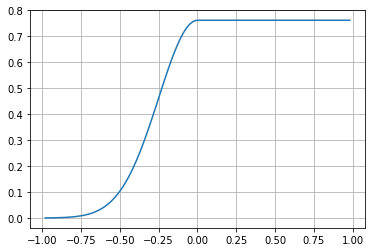

In [116]:
pdf = make_fbeta(D=4)

xs = np.linspace(-1, 1,100)[1:-1]
ys = pdf(xs,E = 0.125)
norm = spint.quad(pdf,-1,1)
# norm = spint.trapz(ys,xs)
print norm
plt.plot(xs,ys)
plt.grid()
plt.show()

(1.0000000000000002, 6.36773078710462e-10)
(0.9999999999866996, 1.4078330744922935e-08)
(1.0000000000080962, 4.147360058859631e-09)


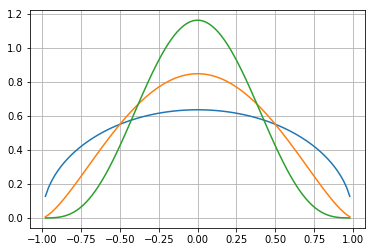

In [128]:
for D in [4,6,10]:
    pdf = zc_beta(D=D)

    xs = np.linspace(-1, 1,100)[1:-1]
    ys = pdf(xs,E = 0.125)
    norm = spint.quad(pdf,-1,1)
    # norm = spint.trapz(ys,xs)
    print norm
    plt.plot(xs,ys)
plt.grid()
plt.show()

(0.9999999999999999, 3.2786896244849095e-11)


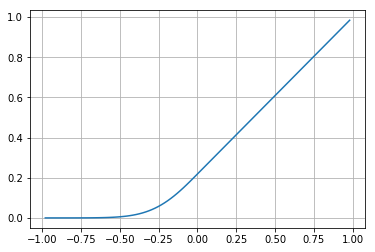

In [242]:

cdf = interp_cdf(pdf)
xs = np.linspace(-1, 1,100)[1:-1]
ys = cdf(xs)
norm = spint.quad(pdf,-1,1)
# norm = spint.trapz(ys,xs)
print norm
plt.plot(xs,ys)
plt.grid()
plt.show()

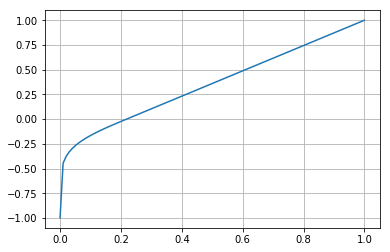

In [243]:
f = cdf

ppf = invert_interp(f)
preview(ppf,rg=[0,1])
plt.show()

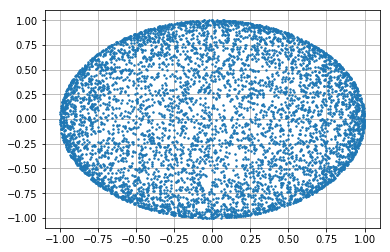

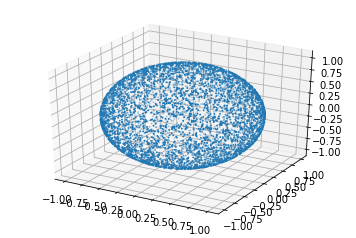

In [228]:
D = 3
n = 6000
pdf = zc_beta(D)
ppf = interp_ppf(pdf)
rvct = spstat.multivariate_normal.rvs(mean=np.zeros(D-1),size=(n,))
x = ppf(np.random.random(n))
vn = rvct / l2_norm(rvct)
v = np.hstack([x[:,None],np.sqrt(1-x**2)[:,None]*vn])
plt.plot(v[:,0],v[:,1],'.',markersize=3)
plt.grid()
plt.show()
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(v[:,0],v[:,1],v[:,2],marker='.',s=3)
plt.show()
# print x,vn

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """


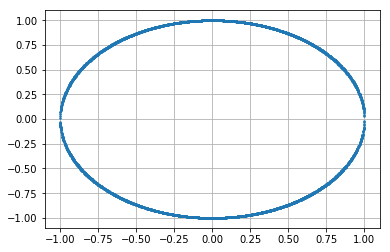

In [215]:
D = 2
n = 6000
pdf = zc_beta(D)
ppf = interp_ppf(pdf,num=1E4)
rvct = spstat.multivariate_normal.rvs(mean=np.zeros(D-1),size=(n,))
if D==2:
    rvct = rvct[:,None]
x = ppf(np.random.random(n))
vn = rvct / l2_norm(rvct)
sin = np.sqrt(1-x**2)
v = np.hstack([x[:,None],sin[:,None]*vn])
plt.plot(v[:,0],v[:,1],'.',markersize=3)
plt.grid()
plt.show()
# print x,vn

In [246]:
vx[:,None]*v0

array([[-0.05844696, -0.        , -0.        ],
       [ 0.42214207,  0.        ,  0.        ],
       [ 0.35269644,  0.        ,  0.        ],
       ...,
       [ 0.8905727 ,  0.        ,  0.        ],
       [ 0.60654627,  0.        ,  0.        ],
       [ 0.20046822,  0.        ,  0.        ]])

https://math.stackexchange.com/questions/432057/how-can-i-calculate-a-4-times-4-rotation-matrix-to-match-a-4d-direction-vector?noredirect=1&lq=1

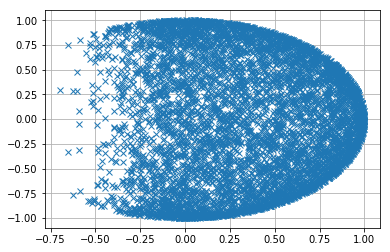

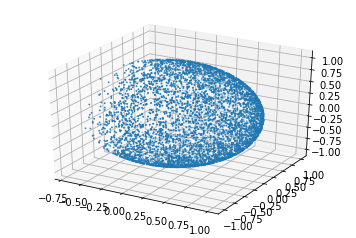

In [317]:
D = 3
n = 6000
v0 = np.zeros(D)
v0[0] = 1.
v0 = v0[None,:]
rvct = spstat.multivariate_normal.rvs(mean=np.zeros(D),size=(n,))
v =  rvct - np.dot(rvct,v0.T)*v0
vy = v/l2_norm(v)
cos = ppf(np.random.random(n))[:,None]
sin = np.sqrt(1-cos**2)
v = (cos*v0+sin*vy)

plt.plot(v[:,0],v[:,1],'x')

# plt.hist(v)
plt.grid()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(v[:,0],v[:,1],v[:,2],marker='.',s=3)
plt.show()

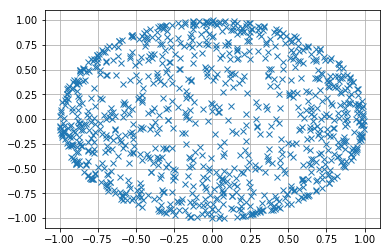

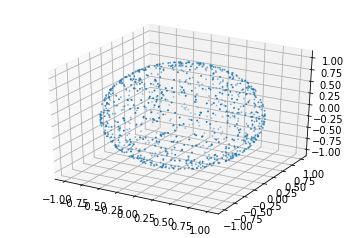

In [351]:


D = 3
n = 6000
pdf = zc_beta(D=3)
ppf = interp_ppf(pdf)
v = radial_randvector(ppf,D=3,n=1000)
plt.plot(v[:,0],v[:,1],'x')
plt.grid()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(v[:,0],v[:,1],v[:,2],marker='.',s=3)
plt.show()

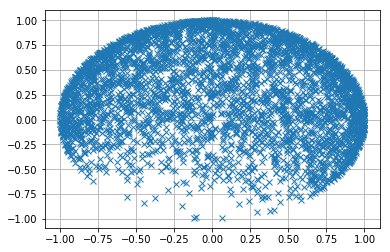

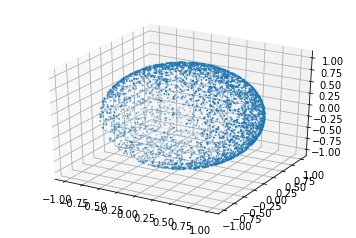

In [348]:
D = 3
n = 6000
# pdf = zc_beta(D=3)
# pdf = fbeta(D=3,)
pdf = make_fbeta(D=D,Edft=0.2)
ppf = interp_ppf(pdf)
v0 = mvrnorm(D,1)
v = radial_randvector(ppf,D=3,n=4000,v0=v0)
plt.plot(v[:,0],v[:,1],'x')
plt.grid()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(v[:,0],v[:,1],v[:,2],marker='.',s=3)
plt.show()

In [349]:
?radial_randvector

In [354]:
??l2_norm

In [353]:
from proba import *
def gradient_randwalk(f,gradF=None,D = None, dt = 0.1):
    if D is None:
        D = f.func_code.co_argcount//2
    if gradF is None:
        gradF = make_gradF(f)
    fbeta = make_fbeta(D=D)
    def adv(IN,i):
        x = IN[:D]
        gd = gradF(*x)
        gdl= l2_norm(gd)
        gdn = np.divide(gd,gdl)
        
        v = radial_randvector(fbeta,D=D,n=1,v0=gdn,E = 1./gdl)
        return np.add(x,np.multiply(v,dt))
    return f